---
title: "Homework 3"
subtitle: ""
author: ""
date: ""
output: 
    pdf_document:
        number_sections: true    
---

knitr::opts_chunk$set(eval = FALSE)

**Due:** end of day Saturday, February 4

**Submission instructions:** Submit one write-up per group on [gradescope.com](gradescope.com). 

**IMPORTANT:** 

- Write names of everyone that worked on the assignment on the submission.
- Specify every member of the group when submitting on Gradescope    
  (https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members)

For this homework, we will be using the case _Retention Modeling at Scholastic Travel Company_. Read:

- Case: Retention Modeling at Scholastic Travel Company (A);
- Supplement: Retention Modeling at Scholastic Travel Company (B);

which are available on Canvas.

Your goal is to help David build a model for retention. 

The following code will get you started.

# Load relevant libraries 

In [3]:
library(dplyr)
library(caret)
library(glmnet)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-6



# Load the data

Here we will load the data from the CSV data file, 
examine its structure, and fix the data types 
incorrectly identified by R when importing from CSV.

In [4]:
STCdata_A<-read.csv('/Users/amankrishna/Git/busn-41204-machine-learning/week4/hw3/travelData.csv')
STCdata_A<-STCdata_A[,-1]

You can use the function `str` to quickly check the internal structure of an R object.
Here we are using it to investigate type of data in each column of the loaded data.

In [5]:
str(STCdata_A)

'data.frame':	2389 obs. of  55 variables:
 $ Program.Code                  : chr  "HS" "HC" "HD" "HN" ...
 $ From.Grade                    : int  4 8 8 9 6 10 11 9 8 8 ...
 $ To.Grade                      : int  4 8 8 12 8 12 12 9 8 8 ...
 $ Group.State                   : chr  "CA" "AZ" "FL" "VA" ...
 $ Is.Non.Annual.                : int  0 0 0 1 0 0 1 0 0 0 ...
 $ Days                          : int  1 7 3 3 6 4 6 8 8 4 ...
 $ Travel.Type                   : chr  "A" "A" "A" "B" ...
 $ Departure.Date                : chr  "1/14/2011" "1/14/2011" "1/15/2011" "1/15/2011" ...
 $ Return.Date                   : chr  "1/14/2011" "1/21/2011" "1/17/2011" "1/17/2011" ...
 $ Deposit.Date                  : chr  "8/30/2010" "11/15/2009" "10/15/2010" "1/7/2011" ...
 $ Special.Pay                   : chr  NA "CP" NA NA ...
 $ Tuition                       : int  424 2350 1181 376 865 2025 1977 3379 2200 1428 ...
 $ FRP.Active                    : int  25 9 17 0 40 9 16 10 30 51 ...
 $ FRP.Cance

Notice that some columns are identified as numerical or integer, but really the should be factors.

For instance, we have that column `From.Grade`

In [6]:
n_distinct(STCdata_A$From.Grade, na.rm = FALSE)   ## n_distinct is a function from dplyr package

[1] 11

only has 11 levels. It might be a better idea to treat it as a factor instead.

You can fix incorrectly classified data types as follows:

In [7]:
STCdata_A <- mutate_at(STCdata_A, vars(From.Grade), as.factor)

We can check that indeed the column represents a factor:

In [8]:
str( STCdata_A$From.Grade )

 Factor w/ 10 levels "3","4","5","6",..: 2 6 6 7 4 8 9 7 6 6 ...


Fix other columns that are numeric at the moment, but could be converted to factors.
The following line first finds numeric columns and then identifies the number of unique elements in each one.

In [9]:
( unique.per.column <- sapply( dplyr::select_if(STCdata_A, is.numeric), n_distinct ) )

To.Grade                 Is.Non.Annual. 
                            11                              2 
                          Days                        Tuition 
                            12                           1230 
                    FRP.Active                  FRP.Cancelled 
                            93                             29 
          FRP.Take.up.percent.                  Cancelled.Pax 
                           476                             34 
            Total.Discount.Pax                    CRM.Segment 
                            26                             12 
           Parent.Meeting.Flag                 MDR.High.Grade 
                             2                             13 
       Total.School.Enrollment            EZ.Pay.Take.Up.Rate 
                           894                            371 
                School.Sponsor                            FPP 
                             2                            146 
                     Total.Pax              SPR.Group.Revenue 
                           159                           1230 
   NumberOfMeetingswithParents DifferenceTraveltoFirstMeeting 
                             3                            343 
 DifferenceTraveltoLastMeeting            SingleGradeTripFlag 
                           252                              2 
      FPP.to.School.enrollment                     FPP.to.PAX 
                          1910                            306 
            Num.of.Non_FPP.PAX              Retained.in.2012. 
                            26                              2

Let us convert every column that has less than 15 unique values into a factor.
The following line identify names of such columns.

In [10]:
( column.names.to.factor <- names(unique.per.column)[unique.per.column < 15] )

[1] "To.Grade"                    "Is.Non.Annual."             
 [3] "Days"                        "CRM.Segment"                
 [5] "Parent.Meeting.Flag"         "MDR.High.Grade"             
 [7] "School.Sponsor"              "NumberOfMeetingswithParents"
 [9] "SingleGradeTripFlag"         "Retained.in.2012."

From this, we can see that the columns 
`To.Grade`, `Is.Non.Annual.`, `Days`,
`CRM.Segment`, `Parent.Meeting.Flag`, `MDR.High.Grade`, 
`School.Sponsor`, `NumberOfMeetingswithParents`, `SingleGradeTripFlag`
can be converted to factors.
We can also convert the output `Retained.in.2012.`

Convert these columns into factors.

In [11]:
STCdata_A <- mutate_at(STCdata_A, column.names.to.factor, as.factor)

Now let's take care of date columns.

In [12]:
date.columns = c('Departure.Date', 'Return.Date', 'Deposit.Date', 'Early.RPL', 'Latest.RPL', 
                 'Initial.System.Date', 'FirstMeeting', 'LastMeeting')
STCdata_A <- mutate_at(STCdata_A, date.columns, function(x) as.Date(x, format = "%m/%d/%Y"))

And finally we change all the character columns to factors as well.

In [13]:
STCdata_A <- mutate_if(STCdata_A, is.character, as.factor)

Let's see what we have:

In [14]:
str(STCdata_A)

'data.frame':	2389 obs. of  55 variables:
 $ Program.Code                  : Factor w/ 28 levels "CC","CD","CN",..: 15 6 7 12 7 6 25 5 1 7 ...
 $ From.Grade                    : Factor w/ 10 levels "3","4","5","6",..: 2 6 6 7 4 8 9 7 6 6 ...
 $ To.Grade                      : Factor w/ 10 levels "3","4","5","6",..: 2 6 6 10 6 10 10 7 6 6 ...
 $ Group.State                   : Factor w/ 54 levels "AB","AK","AL",..: 7 5 11 49 11 20 21 29 5 47 ...
 $ Is.Non.Annual.                : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 2 1 1 1 ...
 $ Days                          : Factor w/ 12 levels "1","2","3","4",..: 1 7 3 3 6 4 6 8 8 4 ...
 $ Travel.Type                   : Factor w/ 4 levels "A","B","N","T": 1 1 1 2 4 1 1 1 1 1 ...
 $ Departure.Date                : Date, format: "2011-01-14" "2011-01-14" ...
 $ Return.Date                   : Date, format: "2011-01-14" "2011-01-21" ...
 $ Deposit.Date                  : Date, format: "2010-08-30" "2009-11-15" ...
 $ Special.Pay                   

Pretty good!!!


# Data preprocessing

The data contains a number of columns with missing values.
Let's investigate. 
The following tells us the number of missing values in each column.

In [15]:
sapply(STCdata_A, function(x) sum(is.na(x)))

Program.Code                     From.Grade 
                             0                            127 
                      To.Grade                    Group.State 
                           150                              0 
                Is.Non.Annual.                           Days 
                             0                              0 
                   Travel.Type                 Departure.Date 
                             0                              0 
                   Return.Date                   Deposit.Date 
                             0                              0 
                   Special.Pay                        Tuition 
                          1917                              0 
                    FRP.Active                  FRP.Cancelled 
                             0                              0 
          FRP.Take.up.percent.                      Early.RPL 
                             0                            673 
                    Latest.RPL                  Cancelled.Pax 
                            19                              0 
            Total.Discount.Pax            Initial.System.Date 
                             0                              8 
                  Poverty.Code                         Region 
                             0                              0 
                   CRM.Segment                    School.Type 
                             4                              0 
           Parent.Meeting.Flag                  MDR.Low.Grade 
                             0                              0 
                MDR.High.Grade        Total.School.Enrollment 
                            68                             91 
                  Income.Level            EZ.Pay.Take.Up.Rate 
                             0                              0 
                School.Sponsor               SPR.Product.Type 
                             0                              0 
              SPR.New.Existing                            FPP 
                             0                              0 
                     Total.Pax              SPR.Group.Revenue 
                             0                              0 
   NumberOfMeetingswithParents                   FirstMeeting 
                             0                            337 
                   LastMeeting DifferenceTraveltoFirstMeeting 
                           337                            337 
 DifferenceTraveltoLastMeeting             SchoolGradeTypeLow 
                           337                              0 
           SchoolGradeTypeHigh                SchoolGradeType 
                             0                              0 
                DepartureMonth              GroupGradeTypeLow 
                             0                              0 
            GroupGradeTypeHigh                 GroupGradeType 
                             0                              0 
              MajorProgramCode            SingleGradeTripFlag 
                             0                              0 
      FPP.to.School.enrollment                     FPP.to.PAX 
                            91                              0 
            Num.of.Non_FPP.PAX            SchoolSizeIndicator 
                             0                              0 
             Retained.in.2012. 
                             0

Dealing with missing values is a challenging problem, which could occupy a quarter of its own.
The purpose of this homework is not to investigate in-depth approaches to dealing with missing values,
but rather to investigate classification. 
For that reason, we take the following simple approach. 

The function `fixNAs` below fixes missing values. 
The function defines reactions:

 - adds a new category "FIXED_NA" for a missing value of a categorical/factor variable;
 - fills zero value for a missing value of a numeric variable;
 - fills "1900-01-01" for a missing value of a date variable.

Then it loops through all columns in the dataframe, 
reads their types, and loops through all the values, 
applying the defined reaction to any missing data point. 
In addition, the function creates a surrogate dummy 
variable for each column containing at least one missing value
(for example, `Special.Pay_surrogate`), which takes a value 
of 1 whenever the original variable (`Special.Pay`) has a
missing value, and 0 otherwise.

In [16]:
# Create a custom function to fix missing values ("NAs") and 
# preserve the NA info as surrogate variables
fixNAs <- function(data_frame){
  # Define reactions to NAs
  integer_reac <- 0
  factor_reac <- "FIXED_NA"
  character_reac <- "FIXED_NA"
  date_reac <- as.Date("1900-01-01")
  
  # Loop through columns in the data frame 
  # and depending on which class the
  # variable is, apply the defined reaction and 
  # create a surrogate
  
  for (i in 1:ncol(data_frame)) {
    if (class(data_frame[,i]) %in% c("numeric","integer")) {
      if (any(is.na(data_frame[,i]))) {
        data_frame[,paste0(colnames(data_frame)[i],"_surrogate")] <-
          as.factor(ifelse(is.na(data_frame[,i]),"1","0"))
        data_frame[is.na(data_frame[,i]), i] <- integer_reac
      }
    } else
      if (class(data_frame[,i]) %in% c("factor")) {
        if (any(is.na(data_frame[,i]))){
          data_frame[,i]<-as.character(data_frame[,i])
          data_frame[,paste0(colnames(data_frame)[i],"_surrogate")] <-
            as.factor(ifelse(is.na(data_frame[,i]),"1","0"))
          data_frame[is.na(data_frame[,i]),i]<-factor_reac
          data_frame[,i]<-as.factor(data_frame[,i])
        }
      } else {
        if (class(data_frame[,i]) %in% c("character")) {
          if (any(is.na(data_frame[,i]))){
            data_frame[,paste0(colnames(data_frame)[i],"_surrogate")]<-
              as.factor(ifelse(is.na(data_frame[,i]),"1","0"))
            data_frame[is.na(data_frame[,i]),i]<-character_reac
          }
        } else {
          if (class(data_frame[,i]) %in% c("Date")) {
            if (any(is.na(data_frame[,i]))){
              data_frame[,paste0(colnames(data_frame)[i],"_surrogate")]<-
                as.factor(ifelse(is.na(data_frame[,i]),"1","0"))
              data_frame[is.na(data_frame[,i]),i]<-date_reac
            }
          }
        }
      }
  }
  
  return(data_frame)
}

We apply the above defined function to our data frame.

In [17]:
STCdata_A<-fixNAs(STCdata_A)

We can see that the columns do not have any missing values any more.

In [18]:
any( sapply(STCdata_A, function(x) sum(is.na(x))) > 0)

[1] FALSE

Next, we combine the rare categories. Levels that do not occur often 
during training tend not to have reliable effect estimates 
and contribute to over-fit. 

Let us check for rare categories in the variable `Group.State`.

In [19]:
table(STCdata_A$Group.State)


            AB             AK             AL             AR             AZ 
             1              5             21             10             53 
       Bermuda             CA             CO             CT Cayman Islands 
             1            718             89             15              1 
            FL             GA             HI             IA             ID 
            62             22              9             35             14 
            IL             IN             KS             KY             LA 
           104             43             26             16             31 
            MA             MD             ME             MI             MN 
            36             15              7             71             51 
            MO             MS             MT             MX             NC 
            43              9              6              3             16 
            ND             NE             NH             NJ             NM 
           

Let us create a custom function to combine rare categories.
The function again loops through all the columns in the dataframe,
reads their types, and creates a table of counts 
for each level of the factor/categorical variables. All
levels with counts less than the `mincount` are combined into "other."
The function combines rare categories into "Other."+the name of the 
original variable (for example, `Other.State`).
This function has two arguments: 

- the name of the dataframe; and 
- the count of observations in a category to define "rare."


In [20]:
combinerarecategories<-function(data_frame,mincount){
  for (i in 1:ncol(data_frame)) {
    a<-data_frame[,i]
    replace <- names(which(table(a) < mincount))
    levels(a)[levels(a) %in% replace] <-
      paste("Other", colnames(data_frame)[i], sep=".")
    data_frame[,i]<-a 
  }
  return(data_frame) 
}

Let us combine categories with $<10$ values in `STCdata` into "Other."
Ultimately, it is going to depend on the person doing the analysis on what
they decide to call ``rare''.

In [21]:
STCdata_A<-combinerarecategories(STCdata_A,10) 

Let us look at `Group.State` again.

In [22]:
table(STCdata_A$Group.State)


Other.Group.State                AL                AR                AZ 
               82                21                10                53 
               CA                CO                CT                FL 
              718                89                15                62 
               GA                IA                ID                IL 
               22                35                14               104 
               IN                KS                KY                LA 
               43                26                16                31 
               MA                MD                MI                MN 
               36                15                71                51 
               MO                NC                NE                NM 
               43                16                42                20 
               NV                NY                OH                OK 
               20                19               

You can investigate other columns to see if everything looks fine.

# Split the data into training and testing sets

This is a very important step, both conceptually and technically.
Conceptually, because the goal of predictive modeling is not to build
a model that fits well the data it trains on, 
but rather one that would best predict the new data.
A test set is in this sense the best representation 
of what the "new data" may look like. Technically, to facilitate comparison
between different models, we need to maintain the same IDs in
the corresponding sets at all times.
We will accomplishes this through two "tricks": 

- a random seed ensures that the random-number generator 
  is initialized identically in each run; and 
- the `inTrain` vector is created once and can then be applied 
  anytime the data needs to be split. 
  
By default, the code sets 500 data points in the test set, 
and the remainder 1,889 into the training set.


In [23]:
# set a random number generation seed to 
# ensure that the split is the same every time
set.seed(233) 

inTrain <- createDataPartition(
  y = STCdata_A$Retained.in.2012.,
  p = 1888/2389, 
  list = FALSE)
df.train <- STCdata_A[ inTrain,]
df.test <- STCdata_A[ -inTrain, ]

Let us check that both the training and test sets have a similar
proportion of positive and negative cases.

In [24]:
print('Training set proportion:')
table(df.train$Retained.in.2012.) / nrow(df.train)
print('Test set proportion:')
table(df.test$Retained.in.2012.) / nrow(df.test)

[1] "Training set proportion:"



        0         1 
0.3928004 0.6071996 

[1] "Test set proportion:"



    0     1 
0.392 0.608 

# Fitting a logistic regression model

Let us fit a logistic regression model with all the variables included on the training set.

In [25]:
lgfit.all <- glm(Retained.in.2012.~ ., 
                 data=df.train, 
                 family="binomial")
summary(lgfit.all)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Retained.in.2012. ~ ., family = "binomial", data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7206  -0.5092   0.2285   0.5545   3.1577  

Coefficients: (44 not defined because of singularities)
                                                                   Estimate
(Intercept)                                                      -1.699e+02
Program.CodeCD                                                    7.495e-01
Program.CodeOther.Program.Code                                    4.205e-01
Program.CodeHC                                                    2.585e-01
Program.CodeHD                                                    2.816e-01
Program.CodeHG                                                   -8.370e-01
Program.CodeHN                                                    5.577e-01
Program.CodeHO                                                    4.023e-01
Program.CodeHS                                                 

The model is overfit. It has too many insignificant variables.

Let us fit a much simpler model. We will use stepwise regressions. 

Recall stepwise regression from BUS 41100 Applied regression course.
See, for example, [Week 9 slides](https://maxhfarrell.com/bus41100_old/).
You can also check Section 6.1.2 of the [ISLR](https://statlearning.com/) book.

There are three approaches to running stepwise regressions: backward, forward and both.
We need to specify criterion for inclusion/exclusion of variables.
We will use one based on Bayesian information criteria.

Observe the process of variables being added to the model,
(labeled by "+" in the output), gradual expansion of the model, 
and improvement of BIC.


In [26]:
# Start from a null model with intercept only, and add one covarite at a time until maximum BIC.
lgfit.null <- glm(Retained.in.2012.~ 1, 
                 data=df.train, family="binomial")

lgfit.selected <- step(lgfit.null,                  # the starting model for our search
                       scope=formula(lgfit.all),    # the largest possible model that we will consider.
                       direction="forward", 
                       k=log(nrow(df.train)),       # by default step() uses AIC, but by
                                                    # multiplying log(n) on the penalty, we get BIC.
                                                    # See ?step -> Arguments -> k
                       trace=1)

Start:  AIC=2538.74
Retained.in.2012. ~ 1

                                           Df Deviance    AIC
+ SingleGradeTripFlag                       1   2129.3 2144.4
+ Is.Non.Annual.                            1   2236.0 2251.1
+ From.Grade                               10   2196.2 2279.2
+ SPR.New.Existing                          1   2265.7 2280.8
+ Total.Pax                                 1   2357.4 2372.5
+ FPP                                       1   2358.5 2373.6
+ FRP.Active                                1   2387.8 2402.8
+ Total.Discount.Pax                        1   2399.9 2415.0
+ Num.of.Non_FPP.PAX                        1   2399.9 2415.0
+ SchoolGradeTypeHigh                       3   2415.0 2445.2
+ SchoolGradeType                           7   2390.5 2450.8
+ To.Grade                                 10   2396.0 2479.0
+ DepartureMonth                            5   2446.3 2491.6
+ SchoolGradeTypeLow                        3   2466.2 2496.3
+ CRM.Segment              

The algorithm stops once none of the 1-step expanded models lead to a lower BIC.

This is the selected model.

In [27]:
summary(lgfit.selected)


Call:
glm(formula = Retained.in.2012. ~ SingleGradeTripFlag + SPR.New.Existing + 
    Is.Non.Annual. + FRP.Active + To.Grade_surrogate + Total.Discount.Pax, 
    family = "binomial", data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8150  -0.7108   0.3982   0.6079   2.7149  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.100495   0.141541   0.710 0.477699    
SingleGradeTripFlag1  1.220935   0.130267   9.373  < 2e-16 ***
SPR.New.ExistingNEW  -1.597414   0.129210 -12.363  < 2e-16 ***
Is.Non.Annual.1      -2.427700   0.194144 -12.505  < 2e-16 ***
FRP.Active            0.023528   0.006669   3.528 0.000419 ***
To.Grade_surrogate1   0.738475   0.235902   3.130 0.001745 ** 
Total.Discount.Pax    0.108888   0.039687   2.744 0.006077 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2531.2  on 1888  degr

You can predict probabilities from this model using the following.

In [28]:
phat.lgfit.selected <- predict(lgfit.selected, 
                               newdata = df.test,
                               type = "response")

You will use these probabilities later.

While we are investigating variable selection in logistic regression models, 
let us also use a more modern approach to variable selection. We will 
use the lasso. 

If you have not seen this in BUS 41100 Applied regression course,
do not worry. We will provide more details in the Week 5.
You can also check Section 6.2.2 of the [ISLR](https://statlearning.com/) book.

I provide the code to fit a lasso logistic regression model.
We find coefficients $\beta$ that minimize the deviance
loss plus the penalty:
\[
-2\cdot\sum_{i=1}^n \log p(y_i, x_i; \beta) + \lambda \sum_{j=1}^p |\beta_j|.
\]
Here, $\lambda$ is the user chosen penalty that controls the flexibility of the fit.

First, we need to create a model matrix that will be used as an input to the package.

In [29]:
X <- model.matrix(formula(lgfit.all), STCdata_A)
#need to subtract the intercept
X <- X[,-1]

X.train = X[ inTrain, ]
X.test = X[ -inTrain, ]

Next, we run 5-fold cross-validation.

In [30]:
cv.l1.lgfit <- cv.glmnet(
  x       = X.train, 
  y       = df.train$Retained.in.2012.,
  family  = "binomial", 
  alpha   = 1,   #alpha=0 gives ridge regression
  nfolds  = 5)

We can plot the cross-validation curve, which shows us an estimate of out-of-sample deviance 
as a function of the tuning parameter $\lambda$.
The x-axis represents to $-\log(\lambda)$. 
Therefore, on the left we have large values of $\lambda$
and on the right we have small values of $\lambda$. 
At the top, you can see the number variables that were selected into the model.
The two vertical dashed lines correspond to $\lambda$ values that 
minimize the cross-validation error and 
the largest value of lambda such that error is within 1 standard error of the minimum.

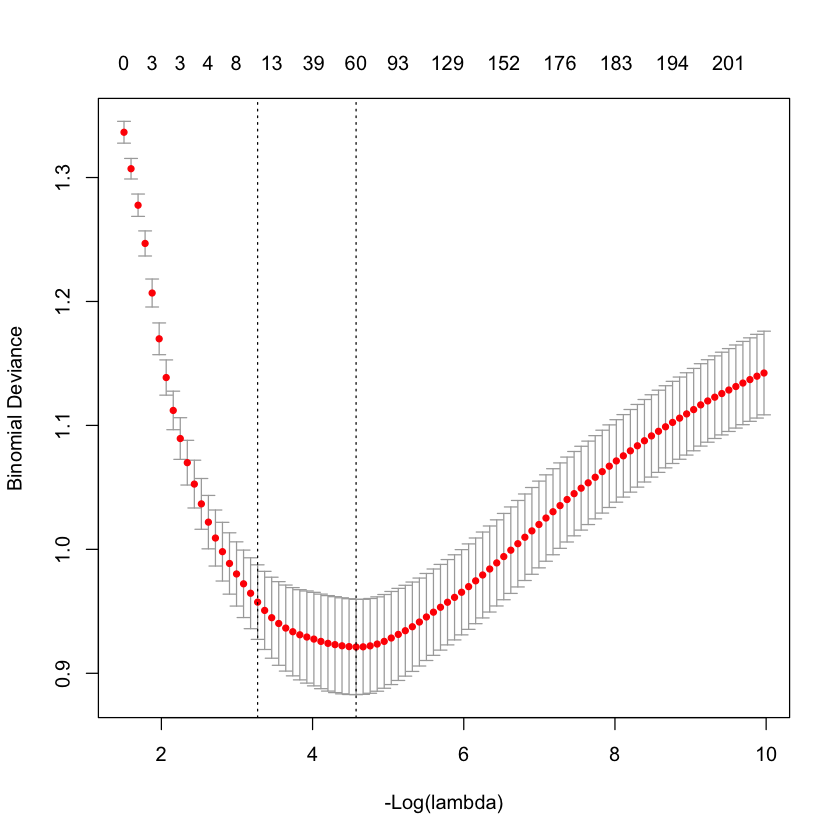

In [31]:
plot(cv.l1.lgfit, sign.lambda=-1)

Let us know plot the fitted coefficients as a function of $\lambda$.
Note that `cv.l1.lgfit$glmnet.fit` corresponds to a fitted glmnet object for the full data.

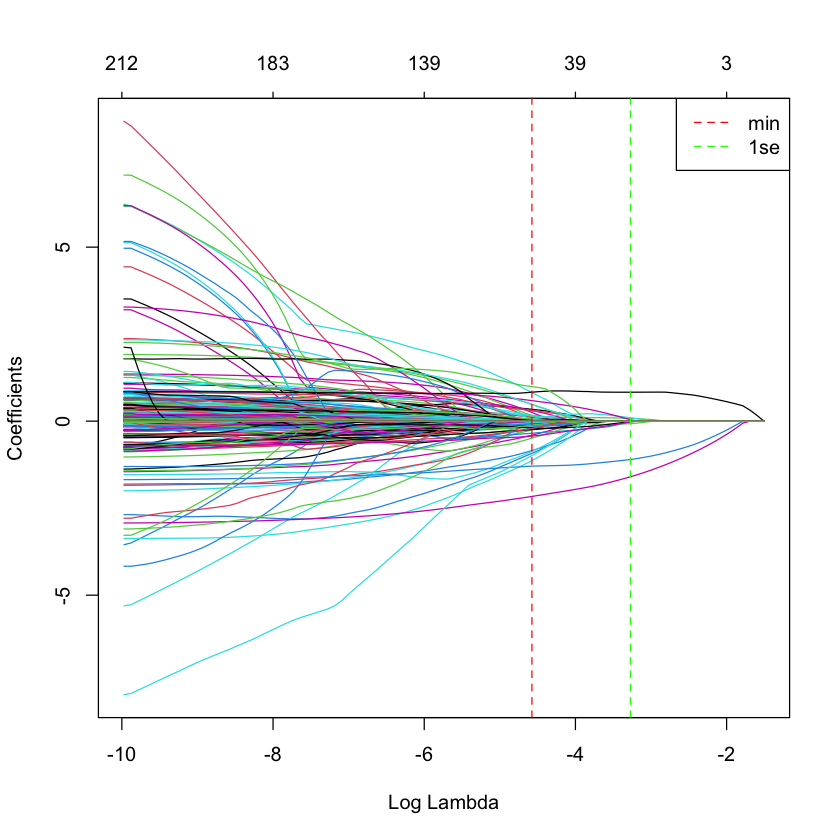

In [32]:
glmnet.fit <- cv.l1.lgfit$glmnet.fit
plot(glmnet.fit, xvar = "lambda")
abline(v = log(cv.l1.lgfit$lambda.min), lty=2, col="red")
abline(v = log(cv.l1.lgfit$lambda.1se), lty=2, col="green")
legend("topright", legend=c("min", "1se"), lty=2, col=c("red", "green"))

For our predictive model, we will use 1 standard error $\lambda$.
Below you can see the variables that are selected by the lasso.

In [33]:
betas <- coef(cv.l1.lgfit, s = "lambda.1se")
model.1se <- which(betas[2:length(betas)]!=0)
colnames(X[,model.1se])

[1] "From.Grade8"             "Is.Non.Annual.1"        
 [3] "FRP.Active"              "Total.Discount.Pax"     
 [5] "CRM.Segment8"            "MDR.High.Grade8"        
 [7] "Income.LevelP"           "SPR.New.ExistingNEW"    
 [9] "Total.Pax"               "SchoolGradeTypeHighHigh"
[11] "DepartureMonthJune"      "SingleGradeTripFlag1"   
[13] "SchoolSizeIndicatorS"

We now use our model to predict probabilities on the test set.

In [34]:
phat.l1.lgfit <- predict(glmnet.fit,
                         newx = X.test,
                         s = cv.l1.lgfit$lambda.1se,
                         type = "response")

# Questions

## How well does logistic regression do?

1. Create a confusion matrix for two logistic regression models build above.
   Use probabilities `phat.lgfit.selected` and `phat.l1.lgfit` to do so.
   
   To solve this question, you need to make a major decision. 
   What should the cutoff or "threshold" for the probability be,
   above which you will label a customer as being classified as "retained?"
   In our case, the data is slightly unbalanced---about 60.72% of data points are in Class 1.
   For very unbalanced data, we would first need to balance it (over- or under-sample).
   In this case, the benefits of balancing are unclear, hence one can implement 
   the average probability of being retained as a cutoff. 
   
   Predict classification using 0.6072 threshold.
   
   What can we see from the confusion matrices?
   
2. Plot ROC curves for the two classifiers and report the area under the curve.

   Note that the AUC of an error-free classifier would be 100%, 
   and an AUC of a random guess would be 50%. For values in-between,
   we can think of AUC as follows:
   
   - 90%+ = excellent,
   - 80–90% = very good, 
   - 70–80% = good, 
   - 60–70% = so-so, and
   - below 60% = not much value.

3. Plot lift curves for the two classifiers.

4. Create the profit curve (the amount of net profit vs the number 
   of groups targeted for promotion) for the two classifiers. 
   Suppose that the benefit of retaining a group is $100, 
   while the cost of a promotion is $40. 
   
   How many groups should be targeted to maximize the profit?
   
   How would this number change as the ratio between the benefit and cost changes?

   You can refer to the following code that plots a profit curve:   
   ```{r}
  # Function to plot a profit curve
  #
  # Inputs:
  #  - benefitTP(FN/FP/TN): the net benefit for a true positive (false negative,...)
  #      which is positive for a gain, and negative for a loss
  #  - y: vector of true labels, which has to be labeled as "0" and "1"
  #  - phat: vector of predicted probabilities
  # Outputs:
  #    the function returns the profit curve
  
  ProfitCurve <- function(benefitTP, benefitFN, benefitFP, benefitTN, y, phat){
    
    if(length(y) != length(phat)) stop("Length of y and phat not identical")
    if(length(levels(y))!=2 | levels(y)[1]!="0" | levels(y)[2]!="1")
      stop("y should be a vector of factors, only with levels 0 and 1")
    
    n <- length(y)
    df <- data.frame(y, phat)
    # Order phat so that we can pick the k highest groups for promotion
    df <- df[order(df[,2], decreasing = T),]
    TP <- 0; FP <- 0; FN <- table(y)[2]; TN <- table(y)[1]
    
    # Initializing the x and y coordinates of the plot
    ratio.vec <- seq(0,n)/n
    profit.vec <- rep(0,n+1)
    profit.vec[1] <- FN * benefitFN + TN * benefitTN
    
    for(k in 1:n){ # k is the number of groups classified as "YES"
      # In every round, we are picking one more group for promotion.
      # If this group was ratained (positive), then in this round, it is classified
      # as a "YES" instead of "NO" before. The confusion matrix is updated each round
      # with one more TP, and one less FN. It's similar when the group was not ratained.
      if(df[k,1]=="1"){TP <- TP + 1; FN <- FN - 1}
      else{FP <- FP + 1; TN <- TN - 1}
      #print(paste(TP, FP, TP-FP, benefitTP, benefitFP))
      profit.vec[k+1] <- TP*benefitTP + FP*benefitFP + FN*benefitFN + TN*benefitTN
    }
    
    plt <- plot(ratio.vec, profit.vec, type="l", lwd=2, col=4, main="Profit Curve",
                xlab="Percentage of Targetted Groups", ylab="Profit")
    abline(b=(profit.vec[n+1]-profit.vec[1]), a=profit.vec[1], lty=2) #Random guess
    return(plt)
  }
  ```

5. Develop a decision tree, random forest, and a boosting model using the training data.
   
   Report ROC, AUC, lift, and profit curves for these models.
   
   How do these methods compare to the logistic regression models?
   
6. Investigate whether David can improve performance of his models using    
   data he received from Emily.
   
   Note that in order to ensure true apples-to-apples comparison, you should
   use the same split of data into train and test.
   
   You can load and merge data as follows. 
   ```{r}
   STCdata_A <- read.csv('travelData.csv')
   STCdata_B <- read.csv('travelData_supplement.csv')
   STCdata_merged = merge(STCdata_A, STCdata_B, by = 'ID')
   STCdata_merged <- STCdata_merged[,-1]
   ```
   Remember to fix missing values and combine rare categories.
   
   Comment on the improvement (or lack thereof) from incorporating the NPS data.
